### Set up

In [ ]:
!pip install transformers

In [ ]:
#lib import
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW # Import AdamW from torch.optim
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime

In [ ]:
#loading dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(0)

print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/fake_news/constraint_train.csv')
val = pd.read_csv('/content/drive/MyDrive/fake_news/constraint_val.csv')
train["label"] = train["label"].map({"real": 1, "fake": 0})
val["label"] = val["label"].map({"real": 1, "fake": 0})

In [ ]:
data = pd.concat([train,val], axis = 0, ignore_index=True).drop(["id"], axis =1)
data

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1
...,...,...
8555,Donald Trump wrongly claimed that New Zealand ...,0
8556,Current understanding is #COVID19 spreads most...,1
8557,Nothing screams “I am sat around doing fuck al...,0
8558,Birx says COVID-19 outbreak not under control ...,0


### TF-IDF + Logistic Regression

In [ ]:
# ---------- TF-IDF + Logistic Regression ----------
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Use your concatenated dataframe: data
df = data.copy()

X = df['tweet'].astype(str)
y = df["label"]

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),   # use bigrams
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

# Logistic Regression model
lr = LogisticRegression(
    max_iter=300,
    solver="liblinear",
    class_weight="balanced"  # useful for imbalance
)

lr.fit(X_train_tfidf, y_train)

# Predictions
probs = lr.predict_proba(X_val_tfidf)[:,1]
preds = (probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, preds))
print("F1:", f1_score(y_val, preds))
print("AUC:", roc_auc_score(y_val, probs))
print("\nClassification Report\n", classification_report(y_val, preds))

Accuracy: 0.9357476635514018
F1: 0.9393605292171996
AUC: 0.9827993697478992

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       408
           1       0.93      0.95      0.94       448

    accuracy                           0.94       856
   macro avg       0.94      0.94      0.94       856
weighted avg       0.94      0.94      0.94       856



### BERT Fine-Tuning + Focal + Class Weights

In [ ]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup


train_losses = []
val_losses = []
val_aucs = []

best_auc = -1

EPOCHS = 4
BATCH_SIZE = 16
MAX_LEN = 128
LR = 2e-5

MODEL_PATH = "/content/drive/MyDrive/fake_news/best_bert_finetuned.pt"

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        prob = torch.sigmoid(logits)
        pt = torch.where(targets == 1, prob, 1 - prob)
        focal = (1 - pt)**self.gamma * bce_loss
        if self.alpha is not None:
            focal = self.alpha[targets.long()] * focal
        return focal.mean()

from transformers import BertModel

class BERTFineTune(nn.Module):
    def __init__(self, pretrained_name):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = out.pooler_output
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled).squeeze(-1)
        return logits

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # Use padding='max_length' instead of pad_to_max_length=True
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        texts=texts.reset_index(drop=True),
        labels=labels.reset_index(drop=True),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)


model = BERTFineTune("bert-base-uncased").to(device)

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

criterion = FocalLoss(alpha=class_weights)

def evaluate(model, data_loader):
    model.eval()
    losses = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            losses.append(loss.item())

            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = np.mean(losses)
    auc = roc_auc_score(all_labels, all_probs)
    preds = (np.array(all_probs) >= 0.5).astype(int)
    f1 = f1_score(all_labels, preds)
    acc = accuracy_score(all_labels, preds)

    return {"loss": avg_loss, "auc": auc, "f1": f1, "acc": acc}


for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    metrics = evaluate(model, val_loader)
    val_losses.append(metrics["loss"])
    val_aucs.append(metrics["auc"])

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {metrics['loss']:.4f}")
    print(f"  Val AUC:    {metrics['auc']:.4f}")
    print(f"  Val F1:     {metrics['f1']:.4f}")
    print("------------------------------")

    if metrics['auc'] > best_auc:
      best_auc = metrics['auc']
      torch.save(model.state_dict(), MODEL_PATH)
      print("  SAVED BEST MODEL")

Class weights: tensor([1.0490, 0.9554], device='cuda:0')
Epoch 1/4
  Train Loss: 0.0535
  Val Loss:   0.0294
  Val AUC:    0.9931
  Val F1:     0.9685
------------------------------
  SAVED BEST MODEL
Epoch 2/4
  Train Loss: 0.0143
  Val Loss:   0.0289
  Val AUC:    0.9954
  Val F1:     0.9757
------------------------------
  SAVED BEST MODEL
Epoch 3/4
  Train Loss: 0.0049
  Val Loss:   0.0338
  Val AUC:    0.9955
  Val F1:     0.9753
------------------------------
  SAVED BEST MODEL
Epoch 4/4
  Train Loss: 0.0014
  Val Loss:   0.0353
  Val AUC:    0.9957
  Val F1:     0.9744
------------------------------
  SAVED BEST MODEL


In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

all_labels = []
all_preds = []
all_probs = [] # Initialize all_probs here

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy().tolist()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int).tolist()

        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs) # Extend all_probs with batch probabilities


import numpy as np
from sklearn.metrics import accuracy_score

acc = accuracy_score(all_labels, all_preds)
print("Validation Accuracy:", acc)

Validation Accuracy: 0.9731308411214953


In [ ]:
from sklearn.metrics import classification_report

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=["fake", "real"]))


=== Classification Report ===
              precision    recall  f1-score   support

        fake       0.98      0.97      0.97       408
        real       0.97      0.98      0.97       448

    accuracy                           0.97       856
   macro avg       0.97      0.97      0.97       856
weighted avg       0.97      0.97      0.97       856



<Figure size 500x400 with 0 Axes>

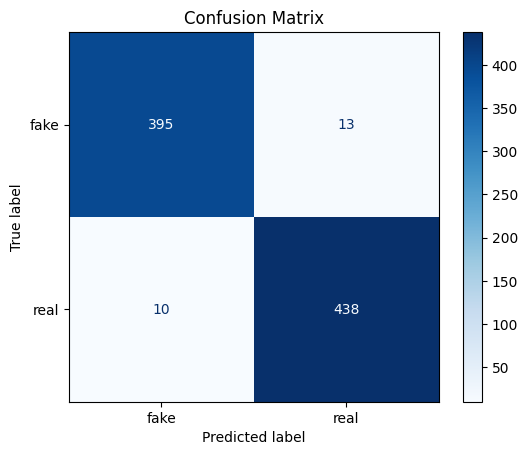

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(cm, display_labels=["fake", "real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

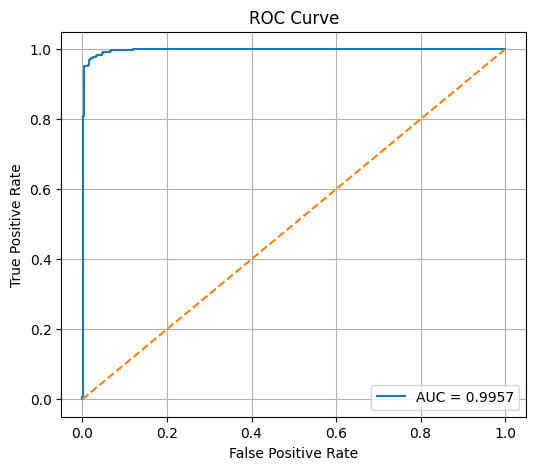

In [ ]:
from sklearn.metrics import roc_curve, auc
# all_probs = [] # Remove initialization here, use the one from previous cell

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

best_t = 0
best_f1 = 0

probs = np.array(all_probs)

for t in np.arange(0.0, 1.01, 0.01):
    preds_t = (probs >= t).astype(int)
    f1 = f1_score(all_labels, preds_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\nBest Threshold = {best_t:.2f} | Best F1 = {best_f1:.4f}")


Best Threshold = 0.71 | Best F1 = 0.9787


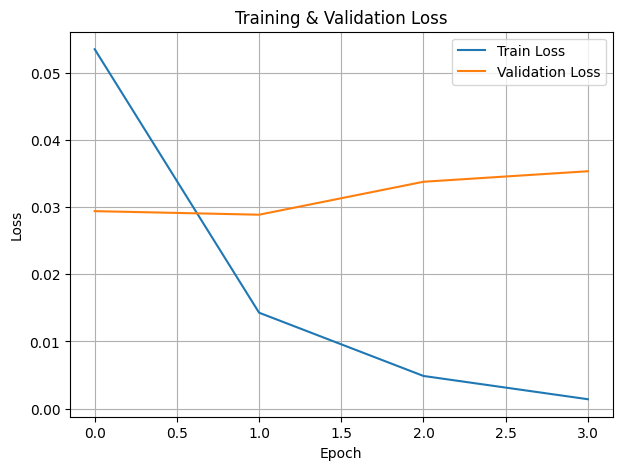

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### DeBERTa-v3

In [ ]:
!pip install transformers==4.36.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.


In [ ]:
# Imports
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW # Import AdamW from torch.optim

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        prob = torch.sigmoid(logits)
        pt = torch.where(targets == 1, prob, 1 - prob)
        loss = ((1 - pt) ** self.gamma) * bce
        if self.alpha is not None:
            loss = self.alpha[targets.long()] * loss
        return loss.mean()

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

def create_loader(texts, labels, tokenizer, max_len, batch):
    ds = TweetDataset(texts, labels, tokenizer, max_len)
    return DataLoader(ds, batch_size=batch, num_workers=2)

class RobertaFineTune(nn.Module):
    def __init__(self, pretrained_name):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_name)
        self.drop = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = out.last_hidden_state[:, 0, :]   # CLS token
        pooled = self.drop(pooled)
        return self.classifier(pooled).squeeze(-1)

Class weights: tensor([1.0490, 0.9554], device='cuda:0')


In [ ]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 4
LR = 1e-5

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_loader = create_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader   = create_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)

model = RobertaFineTune("roberta-base").to(device)
optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

criterion = FocalLoss(alpha=class_weights)

def evaluate(model, loader):
    model.eval()
    losses, labels_all, probs_all = [], [], []

    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(ids, mask)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits).cpu().numpy()

            losses.append(loss.item())
            probs_all.extend(probs.tolist())
            labels_all.extend(labels.cpu().numpy().tolist())

    metrics = {
        "loss": np.mean(losses),
        "auc": roc_auc_score(labels_all, probs_all),
        "f1": f1_score(labels_all, (np.array(probs_all) >= 0.5).astype(int)),
        "acc": accuracy_score(labels_all, (np.array(probs_all) >= 0.5).astype(int))
    }
    return metrics

best_auc = -1
MODEL_PATH = "/content/drive/MyDrive/fake_news/best_roberta.pt"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    val = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {total_loss/len(train_loader):.4f}")
    print(f" Val Loss:   {val['loss']:.4f}")
    print(f" Val AUC:    {val['auc']:.4f}")
    print(f" Val ACC:    {val['acc']:.4f}")
    print(f" Val F1:     {val['f1']:.4f}")

    if val["auc"] > best_auc:
        best_auc = val["auc"]
        torch.save(model.state_dict(), MODEL_PATH)
        print(" ✅ Saved best RoBERTa model")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
 Train Loss: 0.0593
 Val Loss:   0.0300
 Val AUC:    0.9948
 Val ACC:    0.9661
 Val F1:     0.9674
 ✅ Saved best RoBERTa model
Epoch 2/4
 Train Loss: 0.0208
 Val Loss:   0.0253
 Val AUC:    0.9957
 Val ACC:    0.9836
 Val F1:     0.9843
 ✅ Saved best RoBERTa model
Epoch 3/4
 Train Loss: 0.0106
 Val Loss:   0.0328
 Val AUC:    0.9960
 Val ACC:    0.9813
 Val F1:     0.9820
 ✅ Saved best RoBERTa model
Epoch 4/4
 Train Loss: 0.0070
 Val Loss:   0.0356
 Val AUC:    0.9953
 Val ACC:    0.9813
 Val F1:     0.9823


In [ ]:
best_model = RobertaFineTune("roberta-base").to(device)
best_model.load_state_dict(torch.load(MODEL_PATH))
best_model.eval()

final = evaluate(best_model, val_loader)
print("\n=== Final RoBERTa Metrics ===")
print(final)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Final RoBERTa Metrics ===
{'loss': np.float64(0.032793010095061886), 'auc': np.float64(0.9959898021708683), 'f1': 0.9820224719101124, 'acc': 0.9813084112149533}


In [ ]:
# Recompute predictions cleanly
all_labels = []
all_probs = []

best_model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy().tolist()

        logits = best_model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy().tolist()

        all_labels.extend(labels)
        all_probs.extend(probs)

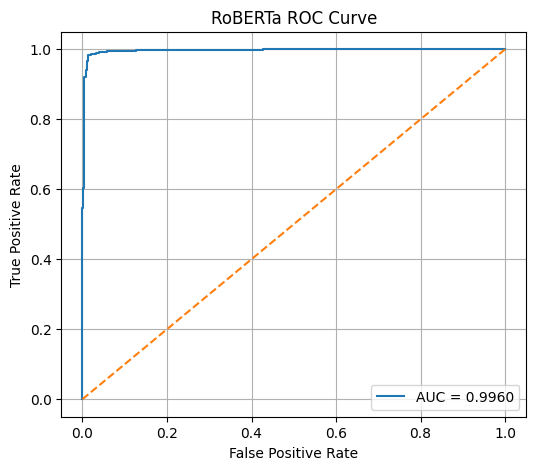

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RoBERTa ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 500x400 with 0 Axes>

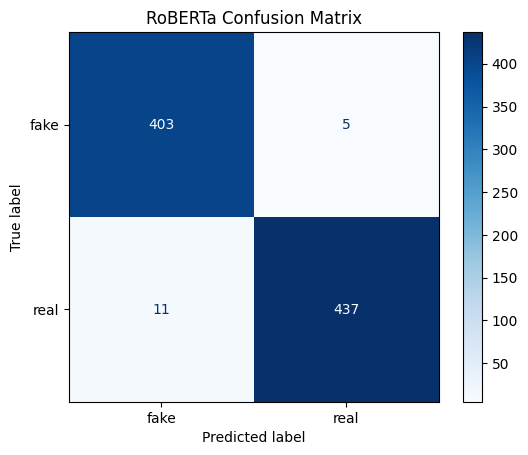

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.5
preds = (np.array(all_probs) >= threshold).astype(int)
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(cm, display_labels=["fake","real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("RoBERTa Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, preds, target_names=["fake","real"]))

              precision    recall  f1-score   support

        fake       0.97      0.99      0.98       408
        real       0.99      0.98      0.98       448

    accuracy                           0.98       856
   macro avg       0.98      0.98      0.98       856
weighted avg       0.98      0.98      0.98       856



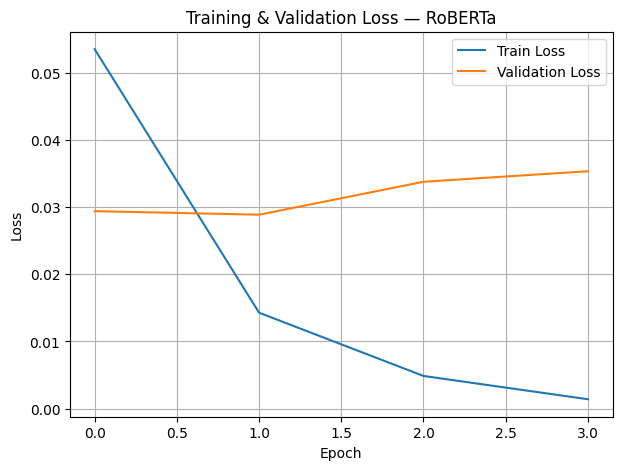

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss — RoBERTa")
plt.legend()
plt.grid(True)
plt.show()

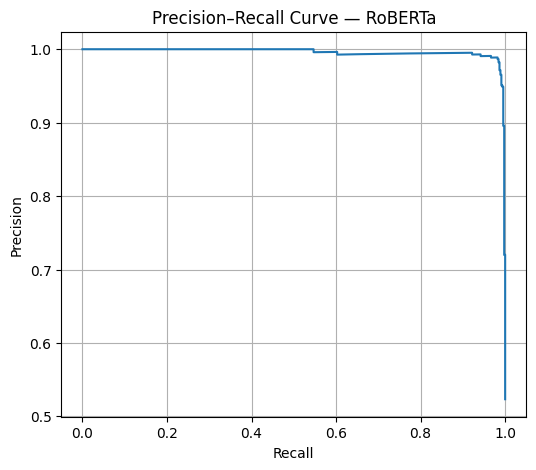

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — RoBERTa")
plt.grid(True)
plt.show()

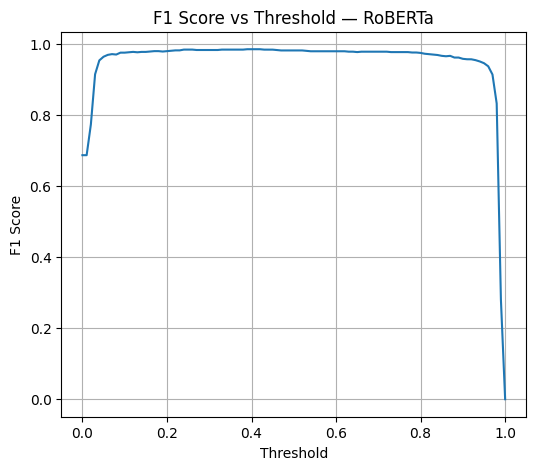

Best Threshold = 0.39, Best F1 = 0.9855


In [ ]:
from sklearn.metrics import f1_score

ts = np.arange(0.0, 1.01, 0.01)
f1s = []

for t in ts:
    preds_t = (np.array(all_probs) >= t).astype(int)
    f1s.append(f1_score(all_labels, preds_t))

plt.figure(figsize=(6,5))
plt.plot(ts, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold — RoBERTa")
plt.grid(True)
plt.show()

best_t = ts[np.argmax(f1s)]
best_f1 = max(f1s)
print(f"Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

### DeBERTa-v3-Large

In [ ]:
!pip install --upgrade transformers torch accelerate

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaV2Tokenizer, DebertaV2Model, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW # Import AdamW from torch.optim

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        prob = torch.sigmoid(logits)
        pt = torch.where(targets == 1, prob, 1 - prob)
        focal = ((1 - pt) ** self.gamma) * bce
        if self.alpha is not None:
            focal = self.alpha[targets.long()] * focal
        return focal.mean()

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

def create_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = TweetDataset(texts, labels, tokenizer, max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=2, shuffle=True)

class DeBERTaV3Large(nn.Module):
    def __init__(self, pretrained_name):
        super().__init__()
        self.deberta = DebertaV2Model.from_pretrained(pretrained_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.deberta.config.hidden_size, 1)  # 1024-dim

    def forward(self, input_ids, attention_mask):
        out = self.deberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = out.last_hidden_state[:, 0, :]  # CLS token
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled).squeeze(-1)
        return logits

MODEL_NAME = "microsoft/deberta-v3-large"

MAX_LEN = 160
BATCH_SIZE = 8       # large model needs smaller batch
LR = 1e-5
EPOCHS = 4

tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

train_loader = create_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader   = create_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model = DeBERTaV3Large(MODEL_NAME).to(device)

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

criterion = FocalLoss(alpha=class_weights)

def evaluate(model, loader):
    model.eval()
    losses, probs_all, labels_all = [], [], []

    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(ids, mask)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits).cpu().numpy()

            losses.append(loss.item())
            probs_all.extend(probs.tolist())
            labels_all.extend(labels.cpu().numpy().tolist())

    preds = (np.array(probs_all) >= 0.5).astype(int)

    return {
        "loss": np.mean(losses),
        "auc": roc_auc_score(labels_all, probs_all),
        "f1": f1_score(labels_all, preds),
        "acc": accuracy_score(labels_all, preds)
    }

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [ ]:
best_auc = -1
SAVE_PATH = "/content/drive/MyDrive/fake_news/deberta_v3_large.pt"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    val = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {total_loss/len(train_loader):.4f}")
    print(f" Val Loss:   {val['loss']:.4f}")
    print(f" Val AUC:    {val['auc']:.4f}")
    print(f" Val ACC:    {val['acc']:.4f}")
    print(f" Val F1:     {val['f1']:.4f}")

    if val["auc"] > best_auc:
        best_auc = val["auc"]
        torch.save(model.state_dict(), SAVE_PATH)
        print(" ✅ Saved best DeBERTa-v3-LARGE")

TypeError: softmax_backward_data() takes 3 positional arguments but 5 were given

In [ ]:
best_model = DeBERTaV3Large(MODEL_NAME).to(device)
best_model.load_state_dict(torch.load(SAVE_PATH))
best_model.eval()

final = evaluate(best_model, val_loader)
print("\n=== Final DeBERTa-v3-LARGE Performance ===")
print(final)